In [1]:
# remove this
import sys
#sys.path.append("/Users/harrison37/Work/alpine/ascent/install-debug/python-modules/")
sys.path.append("/Users/larsen30/research/test_builds/release/ascent/install/python-modules")

In [2]:
# cleanup any old results
!./cleanup.sh

In [3]:
# ascent + conduit imports
import conduit
import conduit.blueprint
import ascent

import numpy as np

# Jupyter imports
from IPython.display import Image
# helper we use when displaying results in the notebook
img_display_width = 500

In [4]:
mesh = conduit.Node()
# create an explicit coordinate set
x = np.array( [-1.0, 0.0, 0.0, 0.0, 1.0 ], dtype=np.float64 )
y = np.array( [0.0, -1.0, 0.0, 1.0, 0.0 ], dtype=np.float64 )
z = np.array( [ 0.0, 0.0, 1.0, 0.0, 0.0 ], dtype=np.float64 )

mesh["coordsets/coords/type"] = "explicit";
mesh["coordsets/coords/values/x"].set_external(x)
mesh["coordsets/coords/values/y"].set_external(y)
mesh["coordsets/coords/values/z"].set_external(z)

# reference the coordinate set by name
mesh["topologies/mesh/type"] = "unstructured"
mesh["topologies/mesh/coordset"] = "coords"
mesh["topologies/mesh/elements/shape"] = "tet"

connectivity = np.array([0, 1, 3, 2, 4, 3, 1, 2 ],dtype=np.int64)
mesh["topologies/mesh/elements/connectivity"].set_external(connectivity)

num_elements = 2
    
var1 = np.array([0,1],dtype=np.float32)
var2 = np.array([1,0],dtype=np.float32)

mesh["fields/var1/association"] = "element"
mesh["fields/var1/topology"] = "mesh"
mesh["fields/var1/volume_dependent"] = "false"
mesh["fields/var1/values"].set_external(var1)

mesh["fields/var2/association"] = "element"
mesh["fields/var2/topology"] = "mesh"
mesh["fields/var2/volume_dependent"] = "false"
mesh["fields/var2/values"].set_external(var2)

In [5]:
# make sure we conform
verify_info = conduit.Node()
if not conduit.blueprint.mesh.verify(mesh,verify_info):
    print("Mesh Verify failed!")
    print(verify_info)
else:
    print("Mesh verify success!")

Mesh verify success!


# Example 1

In [6]:
# render with ascent
a = ascent.Ascent()
a.open()

# publish mesh to ascent
a.publish(mesh);

# declare a scene to render the dataset
scenes = conduit.Node()
scenes["s1/plots/p1/type"] = "pseudocolor";
scenes["s1/plots/p1/field"] = "var1";
scenes["s1/image_prefix"] = "out_scene_ex1_render_var1_";

scenes["s2/plots/p1/type"] = "pseudocolor";
scenes["s2/plots/p1/field"] = "var2";
scenes["s2/image_prefix"] = "out_scene_ex1_render_var2_";

# setup actions
actions = conduit.Node()
add_act = actions.append()
add_act["action"] = "add_scenes"
add_act["scenes"] = scenes

# print our full actions tree
print(actions.to_yaml())

# execute
a.execute(actions)

a.close()


- 
  action: "add_scenes"
  scenes: 
    s1: 
      plots: 
        p1: 
          type: "pseudocolor"
          field: "var1"
      image_prefix: "out_scene_ex1_render_var1_"
    s2: 
      plots: 
        p1: 
          type: "pseudocolor"
          field: "var2"
      image_prefix: "out_scene_ex1_render_var2_"



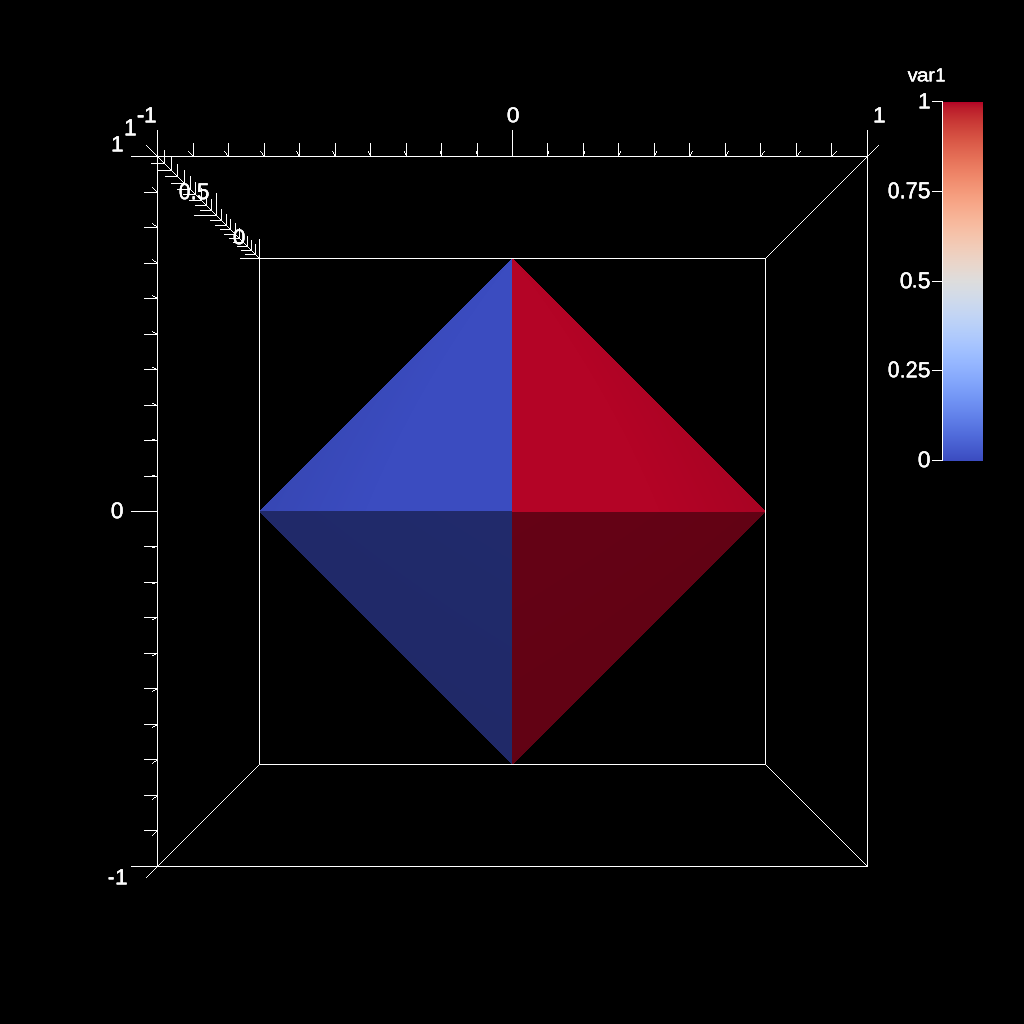

In [7]:
# show the resulting images
Image("out_scene_ex1_render_var1_0.png",width=img_display_width)

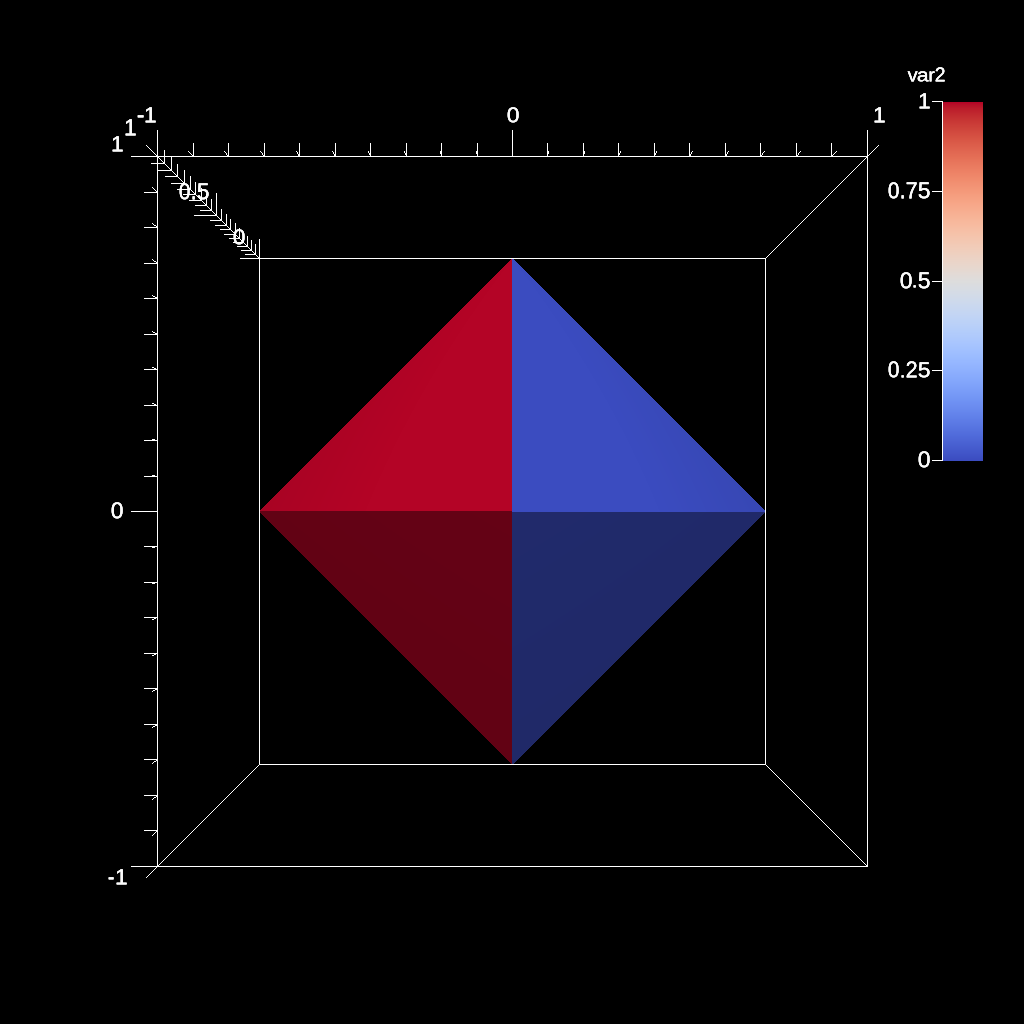

In [8]:
Image("out_scene_ex1_render_var2_0.png",width=img_display_width)

# Example 2

In [9]:
a = ascent.Ascent()
a.open()
a.publish(mesh)

# declare a scene to render the dataset
scenes = conduit.Node()
scenes["s1/plots/p1/type"] = "pseudocolor"
scenes["s1/plots/p1/field"] = "var1"
scenes["s1/plots/p2/type"] = "mesh"
scenes["s1/image_prefix"] = "out_scene_ex2_render_two_plots_"

# setup actions
actions = conduit.Node()
add_act = actions.append()
add_act["action"] = "add_scenes"
add_act["scenes"] = scenes

# print our full actions tree
print(actions.to_yaml())


# execute
a.execute(actions)

a.close()


- 
  action: "add_scenes"
  scenes: 
    s1: 
      plots: 
        p1: 
          type: "pseudocolor"
          field: "var1"
        p2: 
          type: "mesh"
      image_prefix: "out_scene_ex2_render_two_plots_"



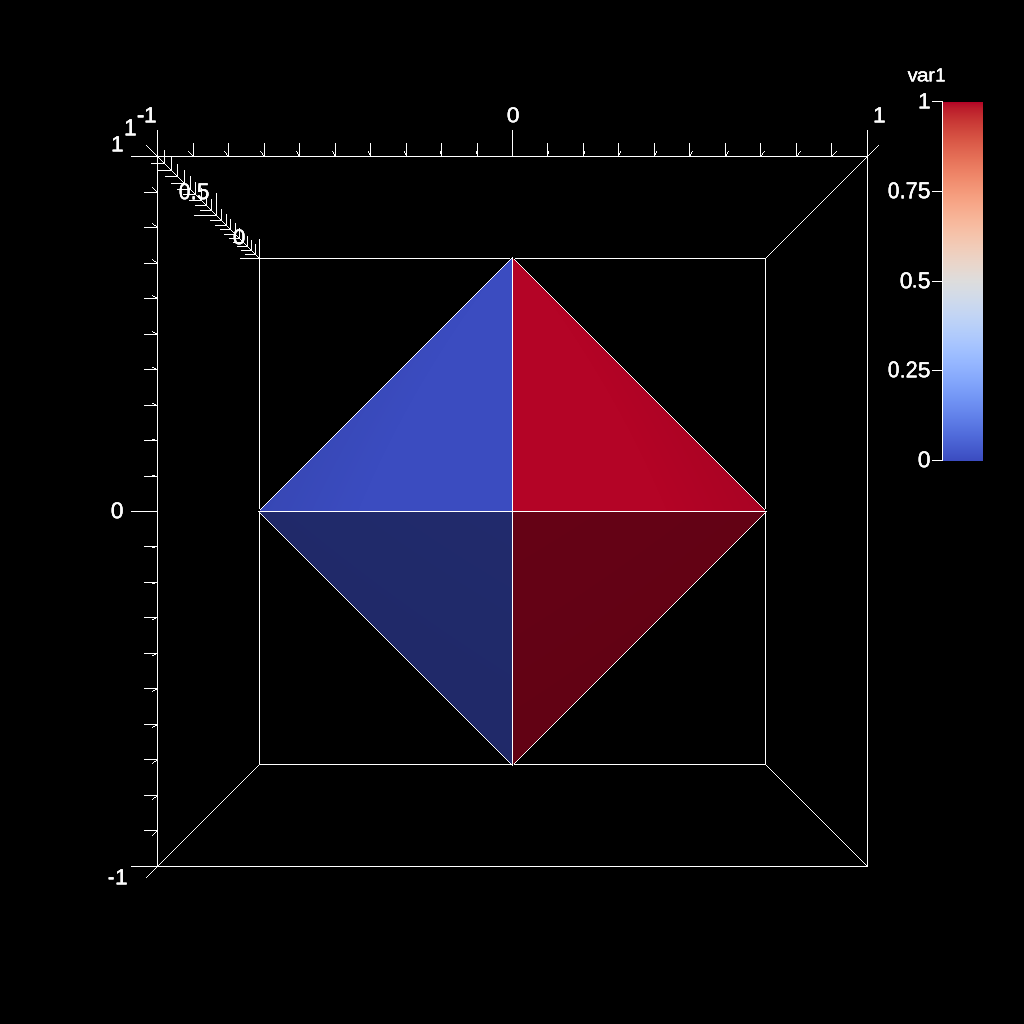

In [10]:
# show the resulting images
Image("out_scene_ex2_render_two_plots_0.png",width=img_display_width)

# Example 3

In [11]:
a = ascent.Ascent()
a.open()
a.publish(mesh)

# declare a scene to render the dataset
scenes = conduit.Node()
scenes["s1/plots/p1/type"] = "pseudocolor"
scenes["s1/plots/p1/field"] = "var1"
scenes["s1/renders/r1/image_name"] = "out_scene_ex2_view1_";
scenes["s1/renders/r2/image_name"] = "out_scene_ex2_view2_";
scenes["s1/renders/r2/camera/zoom"] = 3.0;

# setup actions
actions = conduit.Node()
add_act = actions.append()
add_act["action"] = "add_scenes"
add_act["scenes"] = scenes

# print our full actions tree
print(actions.to_yaml())

# execute
a.execute(actions)

a.close()


- 
  action: "add_scenes"
  scenes: 
    s1: 
      plots: 
        p1: 
          type: "pseudocolor"
          field: "var1"
      renders: 
        r1: 
          image_name: "out_scene_ex2_view1_"
        r2: 
          image_name: "out_scene_ex2_view2_"
          camera: 
            zoom: 3.0



In [12]:
# show the resulting images
Image("out_scene_ex2_view1_0.png",width=img_display_width)

FileNotFoundError: No such file or directory: 'out_scene_ex2_view1_0.png'

FileNotFoundError: No such file or directory: 'out_scene_ex2_view1_0.png'

<IPython.core.display.Image object>

In [13]:
# show the resulting images
Image("out_scene_ex2_view2_0.png",width=img_display_width)

FileNotFoundError: No such file or directory: 'out_scene_ex2_view2_0.png'

FileNotFoundError: No such file or directory: 'out_scene_ex2_view2_0.png'

<IPython.core.display.Image object>

# Example 4

In [14]:
a = ascent.Ascent()
a.open()
a.publish(mesh)

# declare a scene to render the dataset
scenes = conduit.Node()
scenes["s1/plots/p1/type"] = "pseudocolor";
scenes["s1/plots/p1/field"] = "var1"
scenes["s1/plots/p1/color_table/name"] = "Viridis"
scenes["s1/image_prefix"] = "out_scene_ex4_render_viridis_"

scenes["s2/plots/p1/type"] = "pseudocolor"
scenes["s2/plots/p1/field"] = "var1"
scenes["s2/plots/p1/color_table/name"] = "Inferno"
scenes["s2/image_prefix"] = "out_scene_ex4_render_inferno_"

# setup actions
actions = conduit.Node()
add_act = actions.append()
add_act["action"] = "add_scenes"
add_act["scenes"] = scenes

# print our full actions tree
print(actions.to_yaml())


# execute
a.execute(actions)

a.close()


- 
  action: "add_scenes"
  scenes: 
    s1: 
      plots: 
        p1: 
          type: "pseudocolor"
          field: "var1"
          color_table: 
            name: "Viridis"
      image_prefix: "out_scene_ex4_render_viridis_"
    s2: 
      plots: 
        p1: 
          type: "pseudocolor"
          field: "var1"
          color_table: 
            name: "Inferno"
      image_prefix: "out_scene_ex4_render_inferno_"



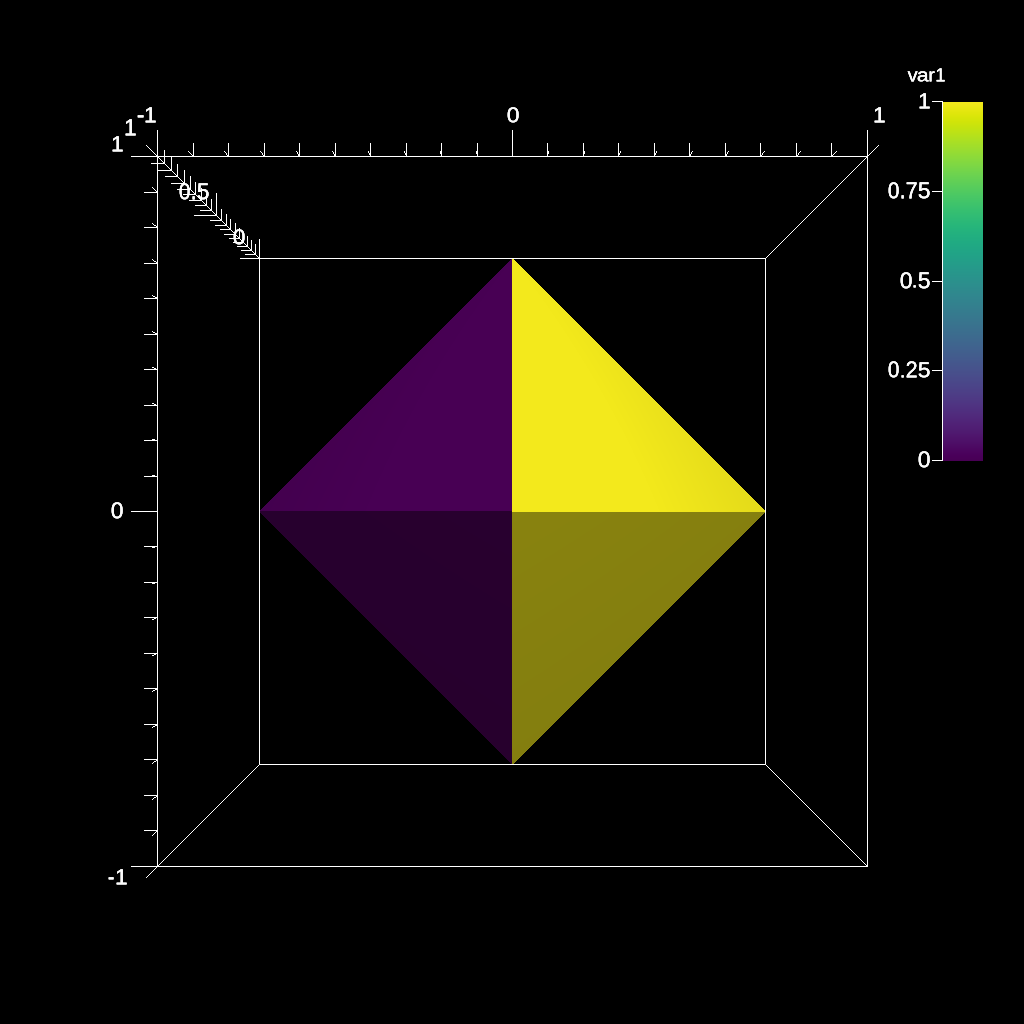

In [15]:
# show the resulting images
Image("out_scene_ex4_render_viridis_0.png",width=img_display_width)

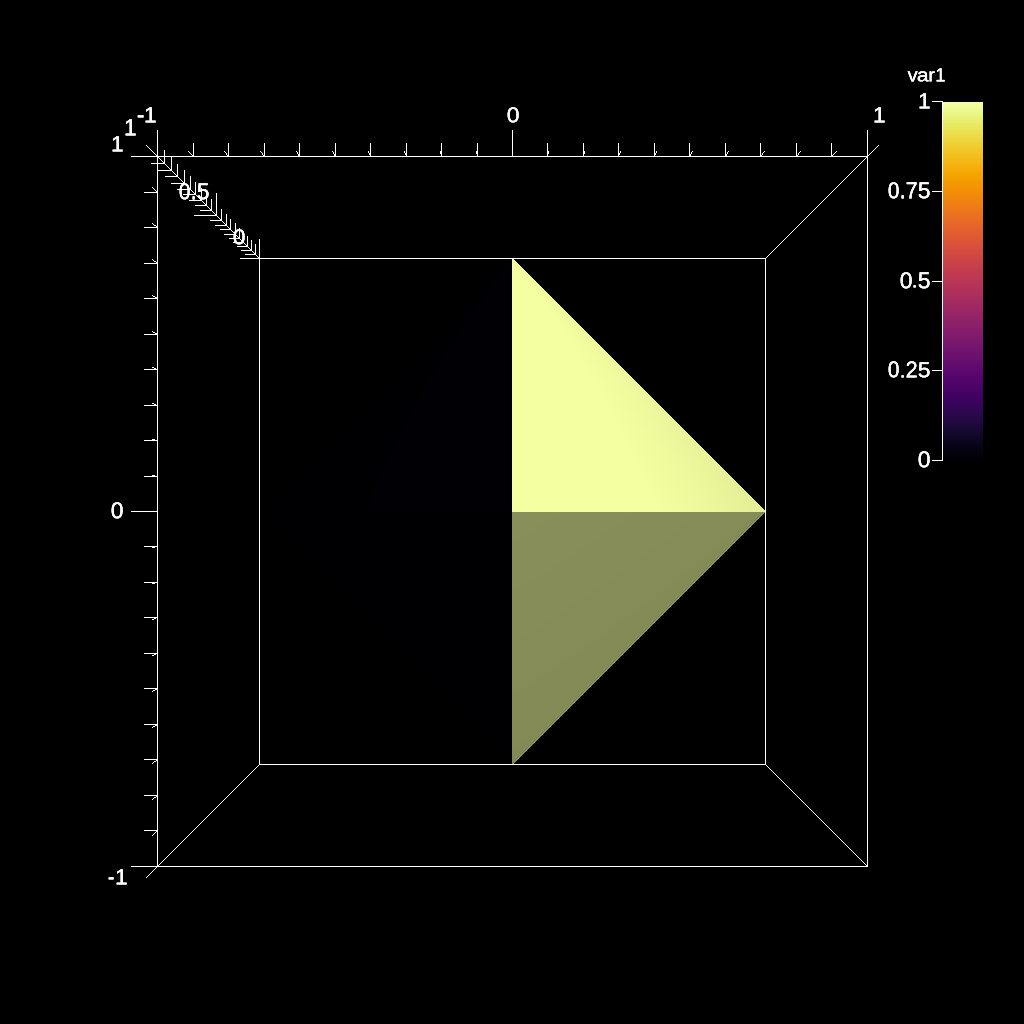

In [16]:
# show the resulting images
Image("out_scene_ex4_render_inferno_0.png",width=img_display_width)